In [20]:
from june.records import RecordReader
import matplotlib.pyplot as plt
import pandas as pd
from utils import read_df

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

plt.style.use(['science','no-latex'])
plt.style.reload_library()

In [6]:
%%time

# read one people df
read = RecordReader(
    results_path='/cosma5/data/durham/covid19/arnau/runs/olympia_variations/results/run_001/'
)
people_df = read.table_to_df('population')

CPU times: user 2min, sys: 25.2 s, total: 2min 25s
Wall time: 2min 55s


In [ ]:
n_runs = 24

In [7]:
%%time


infections_dfs = [read_df(run=run) for run in range(0,n_runs,3)]


CPU times: user 5min 19s, sys: 1min 26s, total: 6min 46s
Wall time: 6min 49s
Compiler : 4.59 s


In [8]:
%%time


deaths_dfs = [
    read_df(root='deaths',run=run) for run in range(0,n_runs,3)
]



CPU times: user 153 ms, sys: 9.44 ms, total: 162 ms
Wall time: 168 ms


Text(0, 0.5, 'Daily Infections')

2021-08-21 10:47:14,586 - matplotlib.font_manager - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


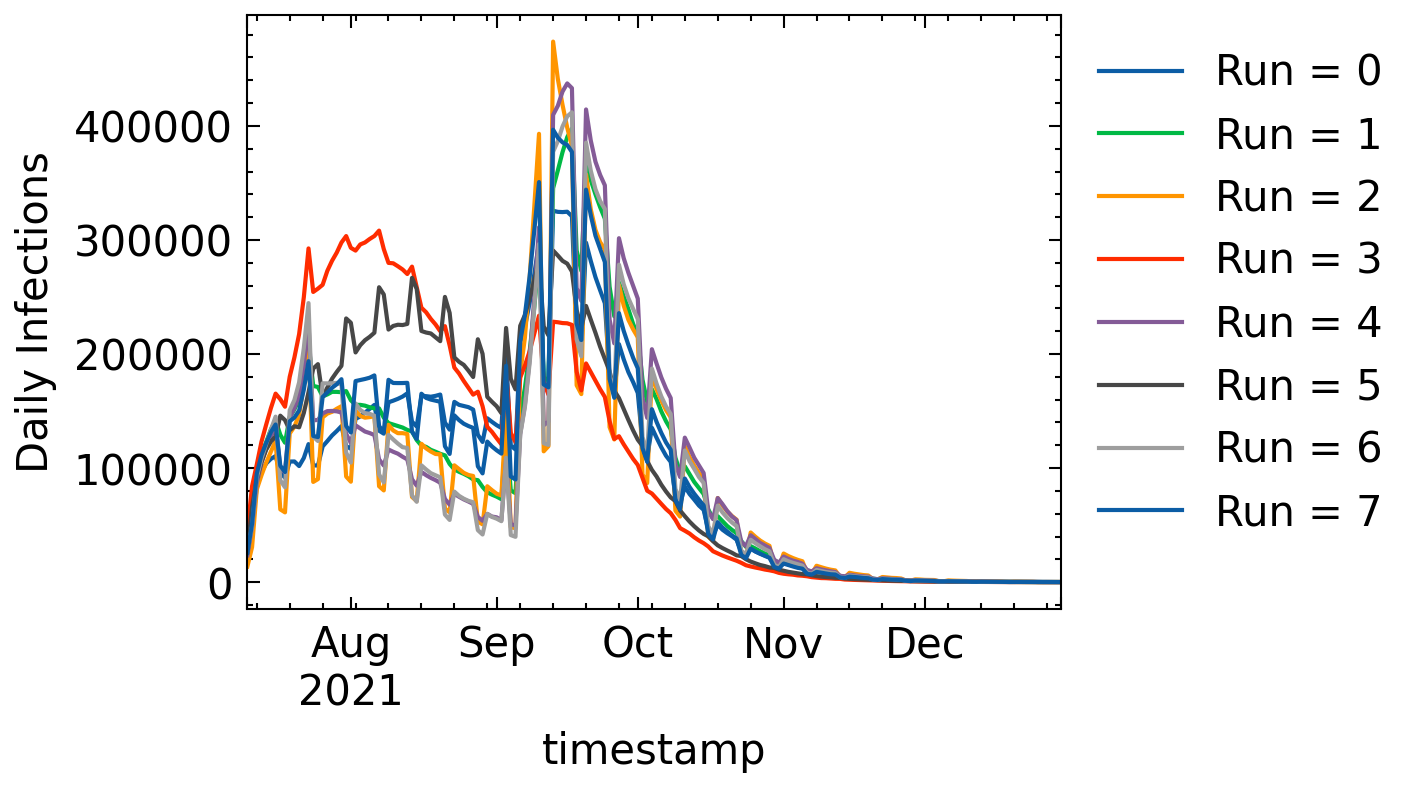

In [9]:
for run, df in enumerate(infections_dfs):
    df.groupby('timestamp').size().plot(label=f'Run = {run}')
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Daily Infections')

Text(0, 0.5, 'Cumulative daily infections')

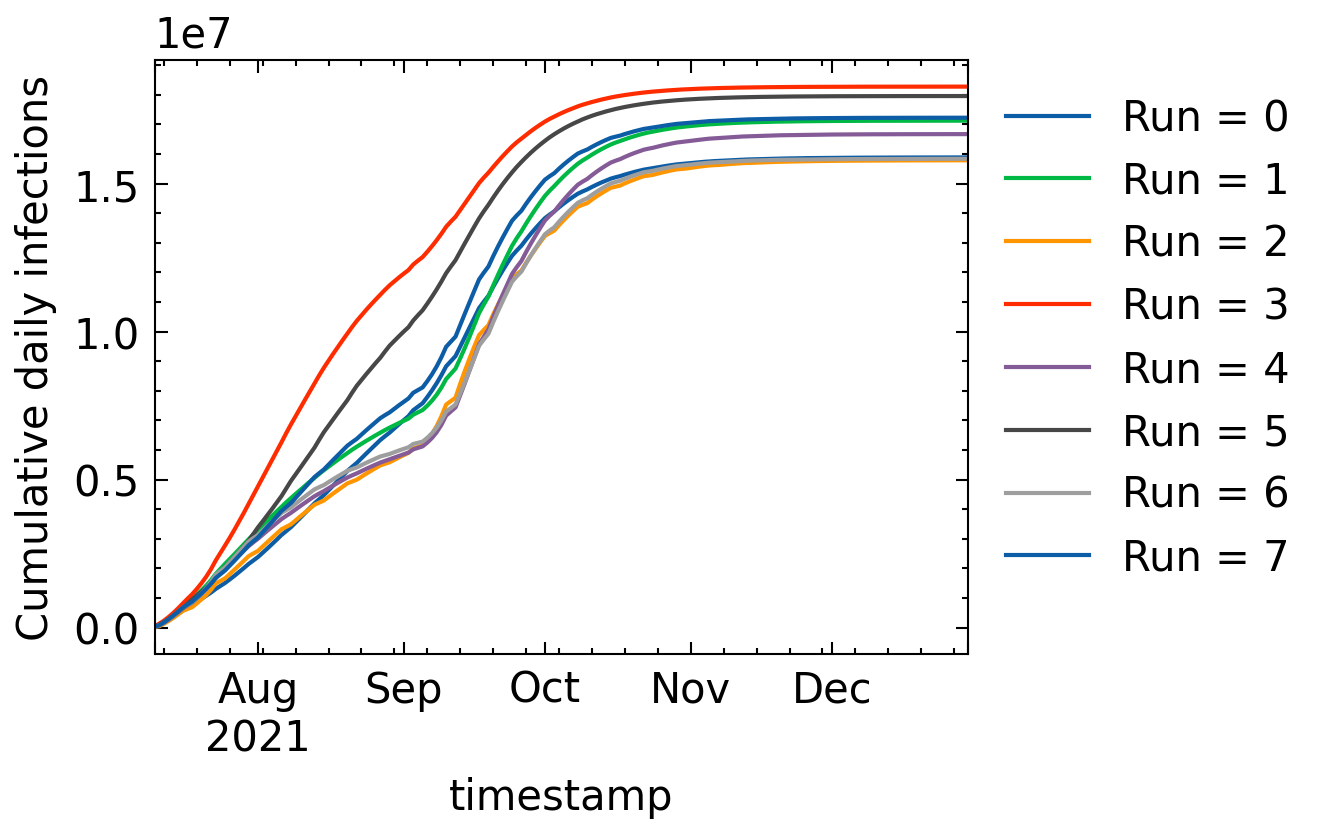

In [10]:
for run, df in enumerate(infections_dfs):
    df.groupby('timestamp').size().cumsum().plot(label=f'Run = {run}')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Cumulative daily infections')

In [11]:
[deaths_dfs[i].groupby('timestamp').size().loc['2021-08-19'] for i in range(len(deaths_dfs))]

[184, 164, 197, 315, 144, 292, 183, 270]

Text(0, 0.5, 'Daily deaths')

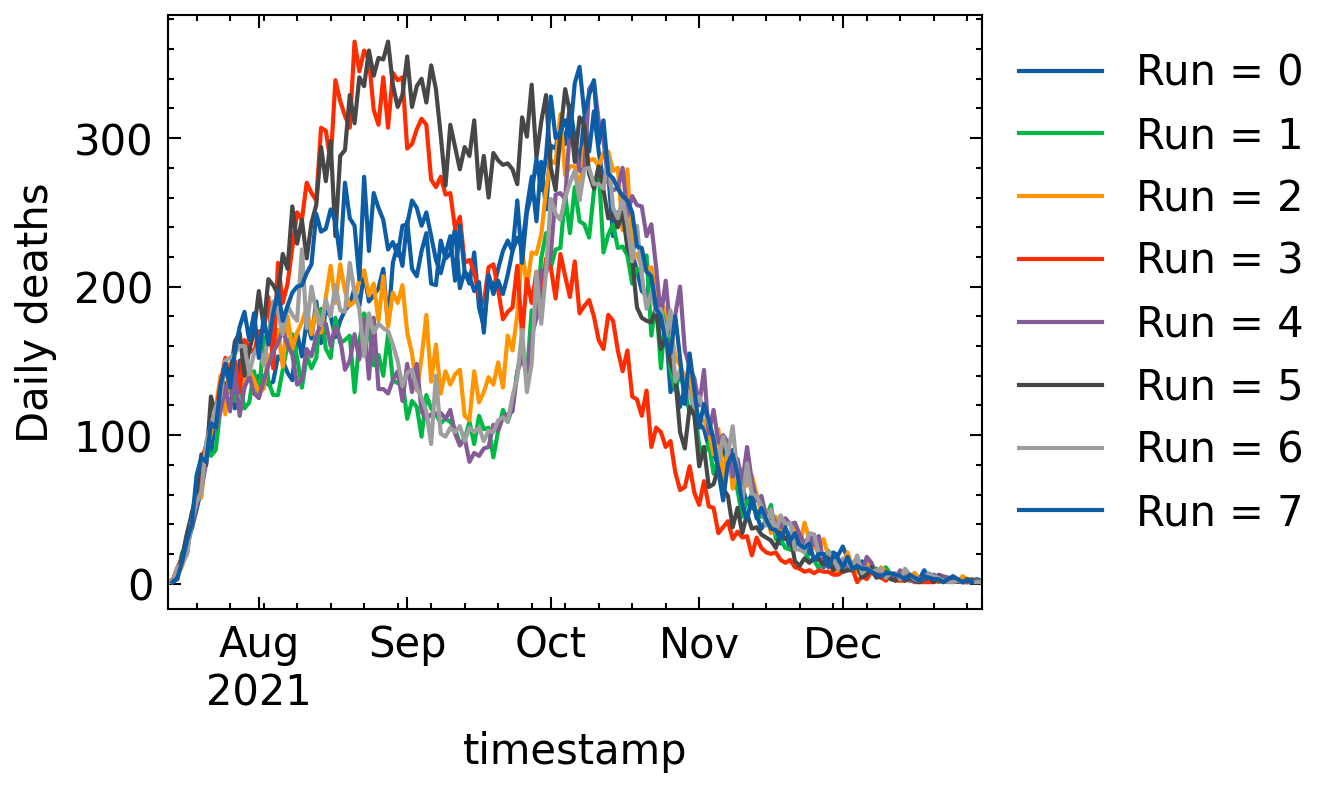

In [12]:
for run, df in enumerate(deaths_dfs):
    df.groupby('timestamp').size().plot(label=f'Run = {run}')
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Daily deaths')

Text(0, 0.5, 'Cumulative deaths')

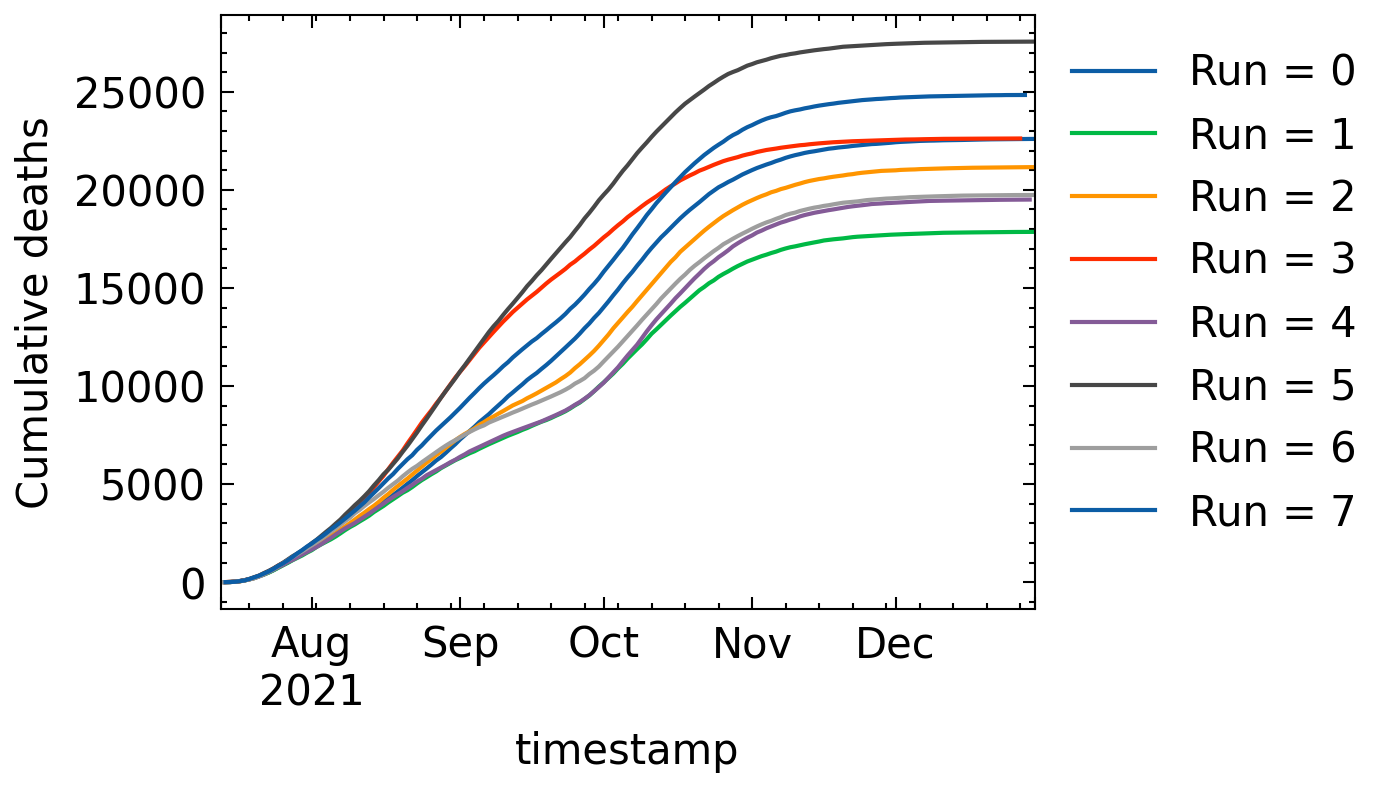

In [13]:
for run, df in enumerate(deaths_dfs):
    df.groupby('timestamp').size().cumsum().plot(label=f'Run = {run}')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Cumulative deaths')

In [14]:
# Do children get herd immunity before schools reopen? Let's check with Run=2

infections_df = infections_dfs[0]

age_bins = (0,12,18,25,35,45,55,65,75,150)

infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()


Text(0.5, 0, '')

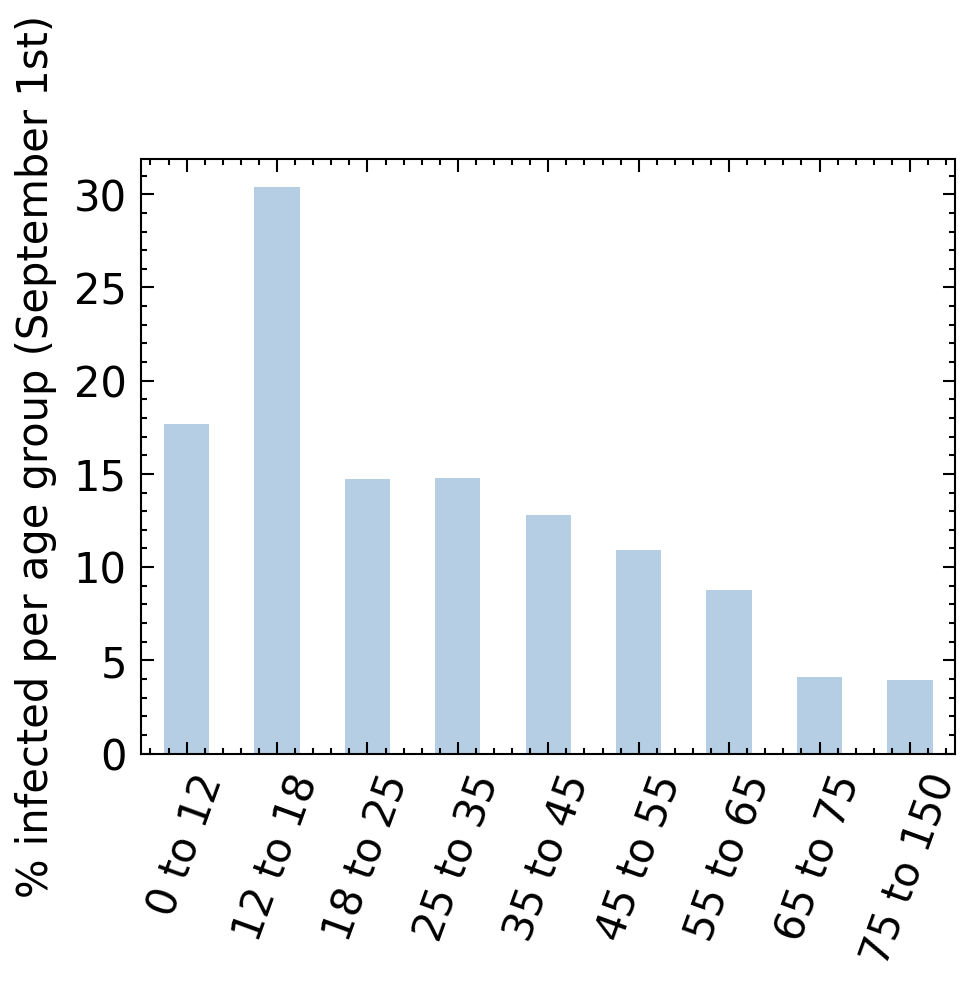

In [15]:
infected_age_plot = (100*infected_by_age/n_by_age).groupby('age').cumsum().loc[:,'2021-09-01']
ax = infected_age_plot.plot.bar(
    rot=0, 
    label='JUNE',
    alpha=0.3,
)
ax.set_xticklabels([str(c)[1:-1].replace(","," to") for c in infected_age_plot.index.categories])
plt.xticks(rotation=70)

plt.ylabel('% infected per age group (September 1st)')
plt.xlabel('')

In [16]:
# Where are they being infected?

In [17]:
teen_infections_df = infections_df[(infections_df['age'] >= 12) & (infections_df['age'] < 18)]

<AxesSubplot:>

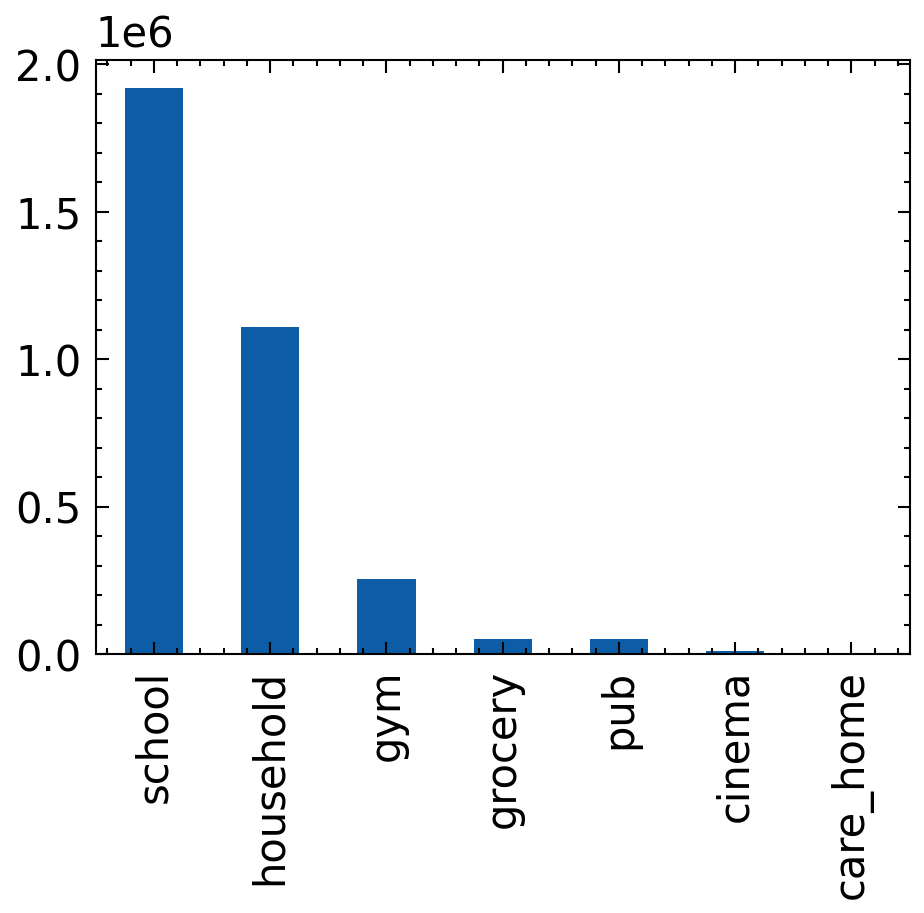

In [18]:
teen_infections_df['location_specs'].value_counts().plot.bar()

<AxesSubplot:>

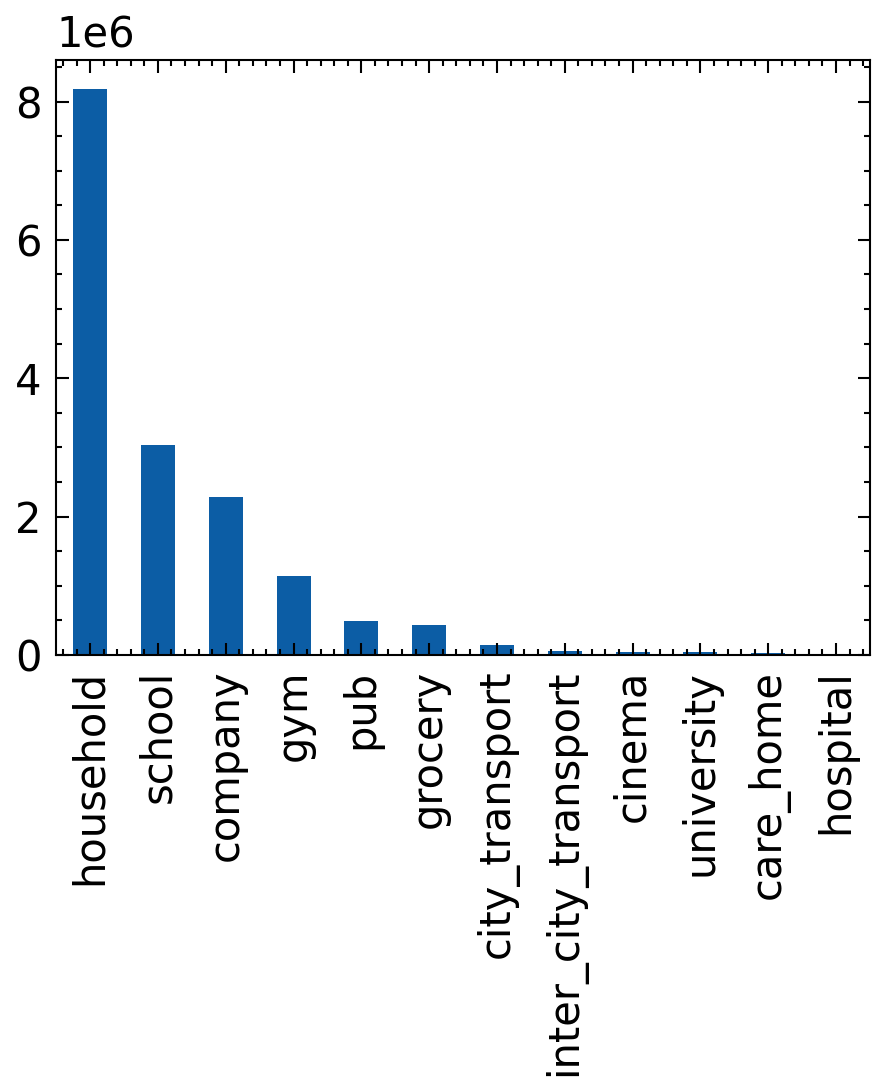

In [19]:
infections_df['location_specs'].value_counts().plot.bar()